In [234]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal,wishart
import sys

# データの確認
## データのロード

In [5]:
df = pd.read_csv("x.csv",header = None) #データをロードしました。
print("データのshape : ",df.shape) #(10000, 3)
df.head()

データのshape :  (10000, 3)


,0,1,2
0,-0.772081,3.30056,-2.14486
1,-1.543720,1.91863,-7.25592
2,6.615610,-1.37613,6.91670
3,-5.519160,2.18445,-2.91299
4,4.744200,-1.61953,4.61999


## 可視化
以下を見る限り、３つのクラスに分割するのが理想に見える・・・

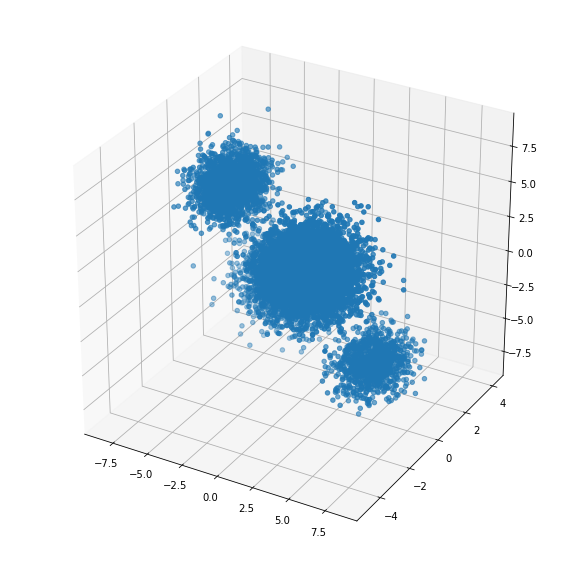

In [33]:
#以下でプロットしています。
rcParams['figure.figsize'] = 10,10
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection="3d")
x = df.values
ax.scatter3D(x.T[0],x.T[1],x.T[2])
plt.show()

# 実装

## EMアルゴリズム
今回はGMMを用いてのEMアルゴリズムを実装した。<br>

In [304]:
class EM:
    def __init__(self,x):
        self.x = x
    def fit(self,step,param_init):
        self.c = len(param_init)
        if step >= 1:
            self.step = step
        else:
            print("ステップ数は１以上にしてください", file=sys.stderr)
            sys.exit(1)
        self.param = {}
        for i in range(3):
            self.param[i] = {}
            #for c in ["pi","m","v"]:
            self.param[i] = param_init[i].copy()
            print("param_init", self.param)
        self.Estep()
    def Estep(self):
        #今回のEステップは混合正規分布の混合比を更新します。
        self.p = [] #現在のパラメータを用いた確率
        for i,para in self.param.items():
            m = para["m"]
            v = para["v"]
            self.p.append(multivariate_normal.pdf(self.x,m,v))
        self.p = np.array(self.p)
        self.g = self.p/np.sum(self.p,axis=0) #ガンマに対応。各データがどの潜在変数に対応するかを示す確率
        self.Mstep()
    def out2(self,x):
        return np.outer(x,x)
    def Mstep(self):
        for c in range(self.c):
            self.param[c]["pi"] = np.sum(self.g[c])/np.sum(self.g)
            self.param[c]["m"] = np.sum((self.x.T*self.g[c]).T,
                                        axis=0)/np.sum(self.g[c])
            m = self.param[c]["m"]
            self.param[c]["v"] = (np.sum((np.apply_along_axis(self.out2,1,self.x).T*self.g[c]).T,axis=0).T
                                  /np.sum(self.g[c])).T - np.outer(m,m)
        print("==============================================================")
        print(self.param)
        self.step = self.step - 1
        if self.step <= 0:
            pass
        else:
            self.Estep()
        
def plot_EM(x,param):
    rcParams['figure.figsize'] = 10,10
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection="3d")
    color = np.array([multivariate_normal.pdf(x,param[i]["m"],param[i]["v"]) for i in range(len(param))]).T
    color = (color.T/np.linalg.norm(color,axis=1)).T
    #color_list.append(color)
    ax.scatter3D(x.T[0],x.T[1],x.T[2],color = color)
    plt.show() 

### 実行結果
今回実装したclass EMは引数として、以下を要求する。<br>
・x : 学習に用いるデータ<br>
・step : 学習を行うステップ数<br>
・param_init : パラメータの初期値<br>

In [336]:
em = EM(x)
param_i = {}
for i in range(3):
    A = np.random.uniform(-10, 10, (3)) #ランダムな行列を平均の初期値として使う
    B = np.random.uniform(-10, 10, (3,3))
    spd = B.dot(B.T) #ランダムな正定値対称行列を分散の初期値として使う
    param_i[i]={"pi" : 1/3,
              "m" : A,
              "v" : spd }

em.fit(20,param_i.copy())
print(em.param)

param_init {0: {'pi': 0.3333333333333333, 'm': array([-8.52283033,  4.5495085 ,  0.22065335]), 'v': array([[92.83821078,  3.60232091, 67.210796  ],
       [ 3.60232091, 20.77712195, -9.2656568 ],
       [67.210796  , -9.2656568 , 84.22786922]])}}
param_init {0: {'pi': 0.3333333333333333, 'm': array([-8.52283033,  4.5495085 ,  0.22065335]), 'v': array([[92.83821078,  3.60232091, 67.210796  ],
       [ 3.60232091, 20.77712195, -9.2656568 ],
       [67.210796  , -9.2656568 , 84.22786922]])}, 1: {'pi': 0.3333333333333333, 'm': array([-4.95142679,  0.43118765, -9.12827936]), 'v': array([[115.09782812,   7.33138383, -18.00069285],
       [  7.33138383, 127.59455004, -89.17524542],
       [-18.00069285, -89.17524542, 137.86970769]])}}
param_init {0: {'pi': 0.3333333333333333, 'm': array([-8.52283033,  4.5495085 ,  0.22065335]), 'v': array([[92.83821078,  3.60232091, 67.210796  ],
       [ 3.60232091, 20.77712195, -9.2656568 ],
       [67.210796  , -9.2656568 , 84.22786922]])}, 1: {'pi': 0.333

{0: {'pi': 0.3578034412750171, 'm': array([-4.26025715,  0.89483655,  1.52772248]), 'v': array([[ 1.78207387,  0.92618226, -3.3365195 ],
       [ 0.92618226,  1.50910843, -3.99092493],
       [-3.3365195 , -3.99092493, 16.69190302]])}, 1: {'pi': 0.2524011327450106, 'm': array([ 0.48106898,  1.06349111, -3.79129757]), 'v': array([[16.95981632, -3.96232607, -3.07627298],
       [-3.96232607,  1.60904635,  0.61280207],
       [-3.07627298,  0.61280207,  2.74034455]])}, 2: {'pi': 0.38979542597997235, 'm': array([ 2.95875047, -2.00620869,  3.06202757]), 'v': array([[1.96155029, 0.0180036 , 0.02274472],
       [0.0180036 , 0.47975111, 0.03246368],
       [0.02274472, 0.03246368, 1.88120176]])}}
{0: {'pi': 0.3356617563753134, 'm': array([-4.33215155,  0.80702594,  1.85714448]), 'v': array([[ 1.73769282,  0.88090033, -3.19684944],
       [ 0.88090033,  1.46845758, -3.83358539],
       [-3.19684944, -3.83358539, 16.07583719]])}, 1: {'pi': 0.2690832741247548, 'm': array([ 0.13007946,  1.2071518 

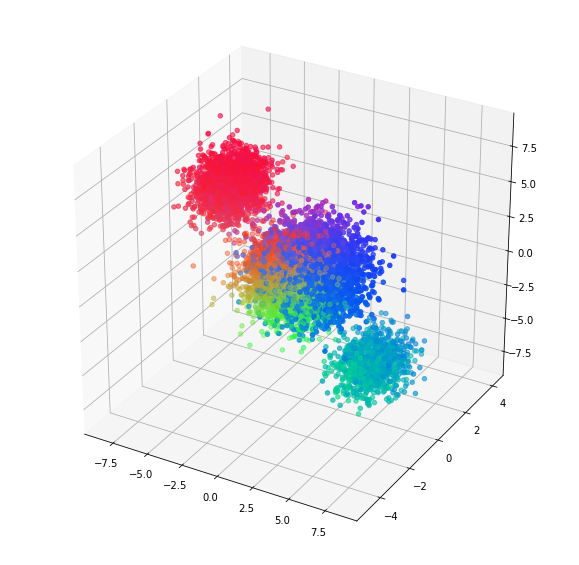

In [337]:
plot_EM(x,param_i) #初期のランダムなパラメータを用いた結果

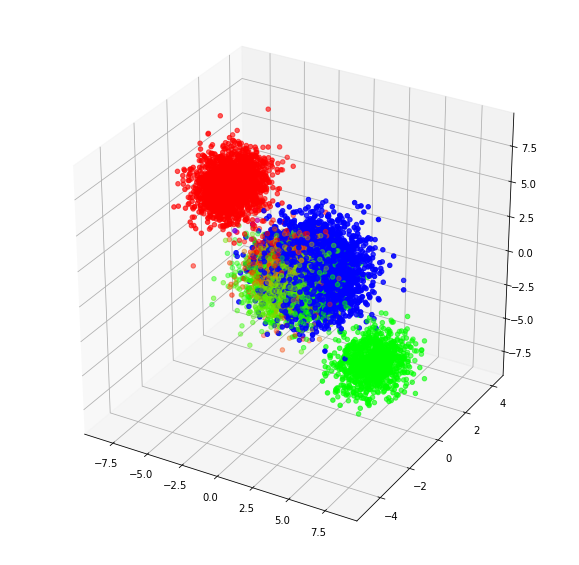

In [338]:
plot_EM(x,em.param) #学習ごのパラメータを用いた結果

## 変分ベイズ

In [157]:
class VB:
    def __init__(self,data):
        self.data = data
    def fit(self,step,param_init):
        if step >= 1:
            self.step = step
        else:
            print("ステップ数は１以上にしてください", file=sys.stderr)
            sys.exit(1)
        self.Estep(self.data,self.step)
    def Estep(self,data,step):
        self.Mstep(self.data,self.step)
    def Mstep(self,data,step):
        self.step = self.step - 1
        if self.step == 0:
            return 1
        else:
            self.Estep(self.data,self.step)

### 実行結果

In [239]:
wishart.pdf(np.ravel(x),df=3,scale=1)

LinAlgError: 1-th leading minor of the array is not positive definite

In [233]:
vb = VB(data = x)
param_i = {}
for i in range(3):
    A = np.random.uniform(-5, 6, (3)) #ランダムな行列を平均の初期値として使う
    B = np.random.uniform(-5, 6, (3,3))
    spd = B.dot(B.T) #ランダムな正定値対称行列を分散の初期値として使う
    param_i[i]={"pi" : 1/3,
              "m" : A,
              "v" : spd }
vb.fit(10, param_i)
print(em.param)

array([[-0.772081,  3.30056 , -2.14486 ],
       [-1.54372 ,  1.91863 , -7.25592 ],
       [ 6.61561 , -1.37613 ,  6.9167  ],
       ...,
       [-6.03685 ,  1.94148 , -5.27942 ],
       [ 3.11438 , -2.1821  ,  1.64958 ],
       [ 3.87056 , -2.64687 ,  3.22179 ]])

## ギブスサンプリング